# The_best_Image_Classifier

With this project, we aim to develop a machine learning model that can accurately classify images as either AI-generated or real. To start, we obtained the CIFLAKE-10 dataset, which contains approximately 100,000 examples evenly distributed between AI and real images. These images are of low resolution (32x32x3). Additionally, we have augmented the dataset by collecting around 1,200 more examples using Beautiful Soup.

### Lets begin with the code

Importing all the necessary libararies 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
import requests
from bs4 import BeautifulSoup
import urllib.parse
import urllib.request
import random
import uuid
from PIL import Image
from io import BytesIO
import pickle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.metrics import Precision,Recall,BinaryAccuracy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report



###    Web Scraping

We utilized Beautiful Soup to develop a function that can download images from a specified URL on a website

In [2]:
# Get the RGB pixel data of the specific image to exclude
specific_image_path = 'image_17e76843.jpg'
with Image.open(specific_image_path) as img:
    excluded_image_data = np.array(img.convert("RGB"))

def download_images_from_directory(url, output_directory, limit):
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }    

    response = requests.get(url, headers=headers)
    #url is requested within the header which helps to either retrieve that page or output an error
    if response.status_code != 200:
        print(f"Failed to retrieve web page. Status code: {response.status_code}")
        return 0

    soup = BeautifulSoup(response.text, 'html.parser')
    #used to parse the responses into parse tree which helps beautiful soup easy to navigate
    image_elements = soup.find_all('img')
    #it is used to find all the image tags located within the soup object   

    image_urls = []
    #to store all the accessable image urls
    for img in image_elements:
        if 'src' in img.attrs:
            src = img['src']
            if src.endswith(('.jpg', '.jpeg')):
                if not src.startswith('http'):
                    src = urllib.parse.urljoin(url, src)
                image_urls.append(src)

    # Shuffle the image URLs to ensure randomness
    random.shuffle(image_urls)

    inserted_count = 0
    failed_downloads = 0
    #till the limit specified it searches whether the image is avaliable for us to insert or not
    for idx, url in enumerate(image_urls[:limit]):
        try:
            file_extension = 'jpg' if url.endswith(('.jpg', '.jpeg')) else ''
            if file_extension:
                response = requests.get(url)
                if response.status_code == 200: #indicates that request is succeded
                    img = Image.open(BytesIO(response.content)).convert("RGB")
                    candidate_image_data = np.array(img)
                    
                    # Compare the candidate image data with the excluded image data
                    if np.array_equal(candidate_image_data, excluded_image_data):
                        continue  # Skip this image
                    
                    #this loop is made so that the image which we want not to be part of our dataset is not replaced at any moment
                    while True:
                        unique_id = str(uuid.uuid4())[:8] #generates an unique id for the corresponding image
                        file_path = os.path.join(output_directory, f"image_{unique_id}.{file_extension}")
                        if os.path.basename(file_path) != "image_17e76843.jpg":
                            break
                    
                    img.save(file_path)
                    inserted_count += 1
        except Exception as e:
            failed_downloads += 1

    return inserted_count

The upcoming 12 cells will involve augmenting the dataset by scraping additional data from the web.

In [3]:
url = 'https://www.freepik.com/free-photos-vectors/real-horses'
output_directory1 = './train/REAL/'
output_directory2 = './test/REAL/'
count1= download_images_from_directory(url, output_directory1, limit=200)
count2= download_images_from_directory(url, output_directory2, limit=50)
print(f"Number of images successfully inserted into directory 1: {count1}")
print(f"Number of images successfully inserted into directory 2: {count2}")

Number of images successfully inserted into directory 1: 64
Number of images successfully inserted into directory 2: 33


In [4]:
second_url = 'https://www.freepik.com/free-photos-vectors/dogs'
second_count1= download_images_from_directory(second_url, output_directory1, limit=200)
second_count2= download_images_from_directory(second_url, output_directory2, limit=50)
print(f"Number of images successfully inserted into directory 1: {second_count1}")
print(f"Number of images successfully inserted into directory 2: {second_count2}")

Number of images successfully inserted into directory 1: 74
Number of images successfully inserted into directory 2: 42


In [5]:
third_url = 'https://www.freepik.com/free-photos-vectors/real-birds'
third_count1= download_images_from_directory(third_url, output_directory1, limit=200)
third_count2= download_images_from_directory(third_url, output_directory2, limit=50)
print(f"Number of images successfully inserted into directory 1: {third_count1}")
print(f"Number of images successfully inserted into directory 2: {third_count2}")

Number of images successfully inserted into directory 1: 64
Number of images successfully inserted into directory 2: 38


In [6]:
fourth_url = 'https://www.freepik.com/free-photos-vectors/real-frog'
fourth_count1= download_images_from_directory(fourth_url, output_directory1, limit=200)
fourth_count2= download_images_from_directory(fourth_url, output_directory2, limit=50)
print(f"Number of images successfully inserted into directory 1: {fourth_count1}")
print(f"Number of images successfully inserted into directory 2: {fourth_count2}")

Number of images successfully inserted into directory 1: 68
Number of images successfully inserted into directory 2: 41


In [7]:
fifth_url = 'https://www.freepik.com/free-photos-vectors/real-cats'
fifth_count1= download_images_from_directory(fifth_url, output_directory1, limit=200)
fifth_count2= download_images_from_directory(fifth_url, output_directory2, limit=50)
print(f"Number of images successfully inserted into directory 1: {fifth_count1}")
print(f"Number of images successfully inserted into directory 2: {fifth_count2}")

Number of images successfully inserted into directory 1: 68
Number of images successfully inserted into directory 2: 32


In [8]:
sixth_url = 'https://www.freepik.com/photos/human'
sixth_count1= download_images_from_directory(sixth_url, output_directory1, limit=150)
sixth_count2= download_images_from_directory(sixth_url, output_directory2, limit=50)
print(f"Number of images successfully inserted into directory 1: {sixth_count1}")
print(f"Number of images successfully inserted into directory 2: {sixth_count2}")

Number of images successfully inserted into directory 1: 60
Number of images successfully inserted into directory 2: 49


In [9]:
ai1_url = 'https://www.dreamstime.com/photos-images/ai-horse.html'
aioutput_directory1='./train/FAKE/'
aioutput_directory2='./test/FAKE/'
ai1_count1= download_images_from_directory(ai1_url, aioutput_directory1, limit=150)
ai1_count2= download_images_from_directory(ai1_url, aioutput_directory2, limit=50)
print(f"Number of images successfully inserted into ai directory 1: {ai1_count1}")
print(f"Number of images successfully inserted into ai directory 2: {ai1_count2}")

Number of images successfully inserted into ai directory 1: 88
Number of images successfully inserted into ai directory 2: 50


In [10]:
ai2_url = 'https://www.freepik.com/free-photos-vectors/ai-dog'
aioutput_directory1='./train/FAKE/'
aioutput_directory2='./test/FAKE/'
ai2_count1= download_images_from_directory(ai2_url, aioutput_directory1, limit=150)
ai2_count2= download_images_from_directory(ai2_url, aioutput_directory2, limit=50)
print(f"Number of images successfully inserted into ai directory 1: {ai2_count1}")
print(f"Number of images successfully inserted into ai directory 2: {ai2_count2}")

Number of images successfully inserted into ai directory 1: 56
Number of images successfully inserted into ai directory 2: 31


In [11]:
ai3_url = 'https://www.freepik.com/free-photos-vectors/bird-ai'
aioutput_directory1='./train/FAKE/'
aioutput_directory2='./test/FAKE/'
ai3_count1= download_images_from_directory(ai3_url, aioutput_directory1, limit=150)
ai3_count2= download_images_from_directory(ai3_url, aioutput_directory2, limit=50)
print(f"Number of images successfully inserted into ai directory 1: {ai3_count1}")
print(f"Number of images successfully inserted into ai directory 2: {ai3_count2}")

Number of images successfully inserted into ai directory 1: 54
Number of images successfully inserted into ai directory 2: 36


In [12]:
ai4_url = 'https://www.freepik.com/free-photos-vectors/frogsgenerative-ai'
aioutput_directory1='./train/FAKE/'
aioutput_directory2='./test/FAKE/'
ai4_count1= download_images_from_directory(ai4_url, aioutput_directory1, limit=150)
ai4_count2= download_images_from_directory(ai4_url, aioutput_directory2, limit=50)
print(f"Number of images successfully inserted into ai directory 1: {ai4_count1}")
print(f"Number of images successfully inserted into ai directory 2: {ai4_count2}")

Number of images successfully inserted into ai directory 1: 55
Number of images successfully inserted into ai directory 2: 39


In [13]:
ai5_url = 'https://www.freepik.com/free-photos-vectors/cat-ai'
aioutput_directory1='./train/FAKE/'
aioutput_directory2='./test/FAKE/'
ai5_count1= download_images_from_directory(ai5_url, aioutput_directory1, limit=150)
ai5_count2= download_images_from_directory(ai5_url, aioutput_directory2, limit=50)
print(f"Number of images successfully inserted into ai directory 1: {ai5_count1}")
print(f"Number of images successfully inserted into ai directory 2: {ai5_count2}")

Number of images successfully inserted into ai directory 1: 55
Number of images successfully inserted into ai directory 2: 36


In [14]:
ai6_url = 'https://www.freepik.com/free-photos-vectors/anime'
aioutput_directory1='./train/FAKE/'
aioutput_directory2='./test/FAKE/'
ai6_count1= download_images_from_directory(ai6_url, aioutput_directory1, limit=150)
ai6_count2= download_images_from_directory(ai6_url, aioutput_directory2, limit=50)
print(f"Number of images successfully inserted into ai directory 1: {ai6_count1}")
print(f"Number of images successfully inserted into ai directory 2: {ai6_count2}")

Number of images successfully inserted into ai directory 1: 60
Number of images successfully inserted into ai directory 2: 38


### Train directory

In [15]:
DATADIR = "./train/"
CATEGORIES = ["REAL", "FAKE"]
IMG_SIZE = 32

### Getting the training data

#### Method 1:Function to store the training data using dynammic creation

In [16]:

training_data=[]

def create_training_data():
    for category in CATEGORIES:
        path=os.path.join(DATADIR,category)
        class_num=CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array=cv2.imread(os.path.join(path,img))
                new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
                training_data.append([new_array,class_num])
            except Exception as e:
                pass

create_training_data()

print(len(training_data))

100766


In [17]:
random.shuffle(training_data)


In [19]:
X=[]
Y=[]

Seperating features and label effectiving using chunks

In [20]:
X_chunks = []
Y_chunks = []

# Define chunk size
chunk_size = 100  # Adjust based on your system's memory capacity

# Iterate over the training data and store features and labels in chunks
for i, (features, label) in enumerate(training_data):
    if i % chunk_size == 0 and i != 0:
        # Convert the chunked data into numpy arrays
        X_chunk = np.array(X_chunks)
        Y_chunk = np.array(Y_chunks)
        
        # Append the chunked data to the main X and Y lists
        X.append(X_chunk)
        Y.append(Y_chunk)
        
        # Clear the chunk lists
        X_chunks = []
        Y_chunks = []

    X_chunks.append(features)
    Y_chunks.append(label)

# Convert the remaining chunked data into numpy arrays and append to X and Y
X_chunk = np.array(X_chunks)
Y_chunk = np.array(Y_chunks)
X.append(X_chunk)
Y.append(Y_chunk)

# Merge all chunks into single arrays
X = np.concatenate(X, axis=0)
Y = np.concatenate(Y, axis=0)

In [21]:
X=np.array(X).reshape(-1,IMG_SIZE,IMG_SIZE,3) #this is done for double 
#check. Note that images are already in required format


In [22]:
print(len(X))
X.shape

100766


(100766, 32, 32, 3)

Storing the dynammic creation within various pickle files for furthur usage

In [23]:
#binary is used so that data is read as it is
#pickle is used to append the data in the serialized manner
pickle_out=open("X.pickle","wb")
#used to specify the file where the dataset has to be written and with what format
pickle.dump(X,pickle_out)
#it creates the data in X in binary mode and writes out to the pickle_out file
pickle_out.close()

pickle_out=open("Y.pickle","wb")
#used to specify the file where the dataset has to be written and with what format
pickle.dump(Y,pickle_out)
#it creates the data in X in binary mode and writes out to the pickle_out file
pickle_out.close()

#### Method2:- In this method you are loading data from already stored file

In [24]:
pickle_inx=open("X.pickle","rb")
#opens a file in read binary mode
X_p=pickle.load(pickle_inx)
#above loads the data in pickle_inx to X
pickle_iny=open("Y.pickle","rb")
Y_p=pickle.load(pickle_iny)

print(X_p.shape)

(100766, 32, 32, 3)


### Viewing and normalizing the data for model training

In [25]:
X[1]

array([[[ 78, 104, 116],
        [ 92, 120, 131],
        [102, 134, 145],
        ...,
        [ 70, 105, 125],
        [118, 158, 206],
        [103, 143, 208]],

       [[ 83, 107, 119],
        [ 74, 100, 112],
        [ 69,  98, 112],
        ...,
        [ 62,  98, 122],
        [117, 157, 209],
        [109, 152, 219]],

       [[ 79,  98, 111],
        [ 73,  95, 107],
        [ 68,  94, 108],
        ...,
        [ 64, 103, 131],
        [107, 151, 205],
        [101, 144, 217]],

       ...,

       [[ 74, 101,  97],
        [ 89, 118, 115],
        [ 91, 122, 123],
        ...,
        [ 85, 133, 134],
        [ 72, 120, 121],
        [ 79, 127, 128]],

       [[ 67,  96,  87],
        [ 82, 113, 106],
        [ 86, 118, 117],
        ...,
        [ 69, 118, 116],
        [ 72, 121, 119],
        [ 89, 138, 136]],

       [[ 51,  83,  72],
        [ 67,  98,  89],
        [ 74, 107, 103],
        ...,
        [ 62, 111, 109],
        [ 67, 116, 114],
        [ 85, 134, 132]]

In [26]:

X=X/255 #Making the image normalized in order to avoid the situation of exploding gradient or vanishing gradient


## Here we begin model specification

##### VGG16 

VGG16 was chosen for its robust training on a diverse range of image features, making it an ideal resource for transfer learning in image classification tasks.

The weights of VGG16 were originally trained on the vast ImageNet dataset, and we are leveraging these pre-trained weights as our starting point for training our model. By setting include_top=False, we have the flexibility to fine-tune the outcomes according to our specific requirements.

In [27]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
for layer in base_model.layers:
    layer.trainable = False

In [28]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [29]:
logdir='logs'

In [30]:
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=logdir)

#### Early stopping

In [31]:

early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # or 'val_accuracy' if you prefer to monitor validation accuracy
    patience=3,          # number of epochs with no improvement after which training will be stopped
    restore_best_weights=True
    # restores the model weights from the epoch with the best value of the monitored quantity
)

In [32]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

##### Splitting the X and Y generated in training and validation 

In [33]:
# Split data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.1, random_state=42)

### Finally now we train our model

In [34]:
hist = model.fit(
    x_train, 
    y_train, 
    batch_size=50, 
    validation_data=(x_val, y_val),  # Use validation data instead of validation split
    epochs=30,
    callbacks=[tensorboard_callback, early_stopping_callback]  # Add early stopping here
)

Epoch 1/30


2024-06-12 20:00:34.886591: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1814/1814 [==============================] - 564s 310ms/step - loss: 0.3919 - accuracy: 0.8220 - val_loss: 0.3427 - val_accuracy: 0.8496
Epoch 2/30
1814/1814 [==============================] - 601s 331ms/step - loss: 0.3382 - accuracy: 0.8527 - val_loss: 0.3098 - val_accuracy: 0.8681
Epoch 3/30
1814/1814 [==============================] - 541s 298ms/step - loss: 0.3181 - accuracy: 0.8628 - val_loss: 0.3002 - val_accuracy: 0.8761
Epoch 4/30
1814/1814 [==============================] - 671s 370ms/step - loss: 0.3054 - accuracy: 0.8683 - val_loss: 0.2912 - val_accuracy: 0.8771
Epoch 5/30
1814/1814 [==============================] - 551s 304ms/step - loss: 0.2960 - accuracy: 0.8739 - val_loss: 0.2857 - val_accuracy: 0.8793
Epoch 6/30
1814/1814 [==============================] - 627s 346ms/step - loss: 0.2875 - accuracy: 0.8793 - val_loss: 0.2761 - val_accuracy: 0.8859
Epoch 7/30
1814/1814 [==============================] - 553s 305ms/step - loss: 0.2817 - accuracy: 0.8806 - val_loss: 0.280

In [35]:
hist.history

{'loss': [0.3918720483779907,
  0.33815526962280273,
  0.3181484639644623,
  0.30543312430381775,
  0.2959865927696228,
  0.28745272755622864,
  0.28172174096107483,
  0.2762208878993988,
  0.2711724042892456,
  0.2653425335884094,
  0.2609720826148987,
  0.25683915615081787,
  0.25407883524894714,
  0.2502264678478241,
  0.24627047777175903,
  0.24361670017242432,
  0.24069322645664215,
  0.23751132190227509,
  0.23166239261627197],
 'accuracy': [0.8220401406288147,
  0.8527054190635681,
  0.8628499507904053,
  0.8682530522346497,
  0.8738876581192017,
  0.8793348670005798,
  0.8805698752403259,
  0.883425772190094,
  0.8865352869033813,
  0.8894684314727783,
  0.8911995887756348,
  0.8925558924674988,
  0.8953566551208496,
  0.896845281124115,
  0.8984551429748535,
  0.8999106884002686,
  0.8998555541038513,
  0.9017521142959595,
  0.9043985605239868],
 'val_loss': [0.34274527430534363,
  0.3097940683364868,
  0.3001614809036255,
  0.2911977767944336,
  0.28572529554367065,
  0.27612

##### Plotting loss and validation losses

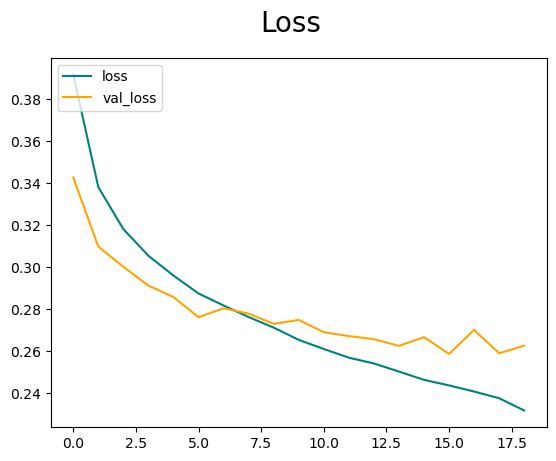

In [36]:
fig=plt.figure()
plt.plot(hist.history['loss'],color='teal',label='loss')
plt.plot(hist.history['val_loss'],color='orange',label='val_loss')
fig.suptitle('Loss',fontsize=20)
plt.legend(loc="upper left")
plt.show()

##### To check that best weigths are maintained

In [37]:
validation_loss = model.evaluate(x_val, y_val)[0]

315/315 [==============================] - 52s 164ms/step - loss: 0.2586 - accuracy: 0.8954


## Analysing the trained model on test data

In [38]:
TESTDIR = "./test/"

In [39]:
pre=Precision()
re=Recall()
acc=BinaryAccuracy()

In [40]:
CATEGORIES = ["REAL", "FAKE"]
IMG_SIZE = 32

In [41]:
test_data=[]

def create_test_data():
    for category in CATEGORIES:
        path=os.path.join(TESTDIR,category)
        class_num=CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array=cv2.imread(os.path.join(path,img))
                new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
                test_data.append([new_array,class_num])
            except Exception as e:
                pass

create_test_data()

print(len(test_data))

20465


In [42]:
random.shuffle(test_data)

In [43]:
X_test=[]
Y_test=[]

In [44]:
X_test_chunks = []
Y_test_chunks = []

# Define chunk size
chunk_size = 100  # Adjust based on your system's memory capacity

# Iterate over the test data and store features and labels in chunks
for i, (features, label) in enumerate(test_data):
    if i % chunk_size == 0 and i != 0:
        # Convert the chunked data into numpy arrays
        X_test_chunk = np.array(X_test_chunks)
        Y_test_chunk = np.array(Y_test_chunks)
        
        # Append the chunked data to the main X_test and Y_test lists
        X_test.append(X_test_chunk)
        Y_test.append(Y_test_chunk)
        
        # Clear the chunk lists
        X_test_chunks = []
        Y_test_chunks = []

    X_test_chunks.append(features)
    Y_test_chunks.append(label)

# Convert the remaining chunked data into numpy arrays and append to X_test and Y_test
X_test_chunk = np.array(X_test_chunks)
Y_test_chunk = np.array(Y_test_chunks)
X_test.append(X_test_chunk)
Y_test.append(Y_test_chunk)

# Merge all chunks into single arrays
X_test = np.concatenate(X_test, axis=0)
Y_test = np.concatenate(Y_test, axis=0)

In [45]:
X_test=np.array(X_test).reshape(-1,IMG_SIZE,IMG_SIZE,3) #for ensuring safety

In [46]:
X_test=X_test/255 #normalizing for checking

### The Results

In [47]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

# Make predictions on the test data
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()

# Update the metrics
precision.update_state(Y_test, y_pred_classes)
recall.update_state(Y_test, y_pred_classes)
accuracy.update_state(Y_test, y_pred_classes)

# Calculate the final results
precision_result = precision.result().numpy()
recall_result = recall.result().numpy()
accuracy_result = accuracy.result().numpy()

print(f'Precision: {precision_result:.4f}')
print(f'Recall: {recall_result:.4f}')
print(f'Accuracy: {accuracy_result:.4f}')


640/640 [==============================] - 105s 165ms/step
Precision: 0.8974
Recall: 0.8733
Accuracy: 0.8868


In [48]:
print(len(X_test))
model.save('model.h5')

20465


In [49]:
# Load the saved model (if not already loaded)
model = load_model('model.h5')

# Make predictions on the test data
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()

# Calculate the confusion matrix
cm = confusion_matrix(Y_test, y_pred_classes)

# Generate a classification report
report = classification_report(Y_test, y_pred_classes, target_names=CATEGORIES)

# Print the confusion matrix and classification report
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(report)


640/640 [==============================] - 107s 168ms/step
Confusion Matrix:
[[9214 1021]
 [1296 8934]]

Classification Report:
              precision    recall  f1-score   support

        REAL       0.88      0.90      0.89     10235
        FAKE       0.90      0.87      0.89     10230

    accuracy                           0.89     20465
   macro avg       0.89      0.89      0.89     20465
weighted avg       0.89      0.89      0.89     20465



### Finally proving that the dataset we used was quite balanced

In [51]:

# Ensure that the shapes and distributions are correct
print("Training data shape:", X.shape)
print("Training labels distribution:", np.bincount(Y))
print("Test data shape:", X_test.shape)
print("Test labels distribution:", np.bincount(Y_test))


Training data shape: (100766, 32, 32, 3)
Training labels distribution: [50398 50368]
Test data shape: (20465, 32, 32, 3)
Test labels distribution: [10235 10230]


In [52]:
print(cm)

[[9214 1021]
 [1296 8934]]
